In [1]:
import os
import sys
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import random
from sklearn.metrics import roc_auc_score, roc_curve, auc

# plotting 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# DeepLearning 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [2]:
print(np.__version__)
print(torch.__version__)
!nvidia-smi

1.26.4
2.4.0
Sat Nov 23 17:39:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [3]:
DATA_FOLDER = '/kaggle/input/shapenet-core-seg/Shapenetcore_benchmark/'

class_name_id_map = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

#class_name_id_map = { 'Car': 3,'Motorbike': 10,}

class_id_name_map = {v:k for k,v in class_name_id_map.items()}

PCD_SCENE=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False), aspectmode='data')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_split_data = json.load(open('/kaggle/input/shapenet-core-seg/Shapenetcore_benchmark/train_split.json', 'r'))
train_class_count = np.array([x[0] for x in train_split_data])

In [5]:
# plot classwise count in train set
train_dist_plots = [go.Bar(x=list(class_name_id_map.keys()), y= np.bincount(train_class_count))]

layout = dict(title="Train dataset", title_x=0.5)

fig = go.Figure(data=train_dist_plots, layout=layout)   
fig.show()


In [6]:
points_list = glob.glob("/kaggle/input/shapenet-core-seg/Shapenetcore_benchmark/04379243/points/*.npy")
print(len(points_list))

5263


In [7]:
idx = random.randint(0,len(points_list))

# load point cloud data
points = np.load(points_list[idx])
print(f"points shape = {points.shape}, min xyz = {np.min(points, axis=0)}, max xyz = {np.max(points, axis=0)}")

# load segmentation lables
seg_file_path = points_list[idx].replace('points', 'points_label').replace('.npy', '.seg')
seg_labels = np.loadtxt(seg_file_path).astype(np.int8)
print(f"seg_labels shape = {seg_labels.shape}, unique labels = {np.unique(seg_labels)}")

points shape = (2748, 3), min xyz = [-0.23661 -0.30621 -0.31662], max xyz = [0.23    0.30621 0.31662]
seg_labels shape = (2748,), unique labels = [1 2]


In [8]:
sys.path.append('/kaggle/input/lidar-od-scripts/gpuVersion/gpuVersion/')

In [9]:
from visual_utils import plot_pc_data3d, plot_bboxes_3d

In [10]:
# there are max of 16 parts in an object in Shapenet core dataset
# creating random colors in according to part label
NUM_PARTS = 16
PART_COLORS = np.random.choice(range(255),size=(NUM_PARTS,3))
PART_COLORS0 = np.random.choice(range(255),size=(NUM_PARTS,3))

In [11]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, color=PART_COLORS[seg_labels - 1], marker_size=2)
layout = dict(template="plotly_dark", title="Raw Point cloud", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

In [12]:
class ShapeNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split_type, num_samples=2500):
        self.root_dir = root_dir
        self.split_type = split_type
        self.num_samples = num_samples
        with open(os.path.join(root_dir, f'{self.split_type}_split.json'), 'r') as f:
            self.split_data = json.load(f)       
            
    def __getitem__(self, index):
        # read point cloud data
        class_id, class_name, point_cloud_path, seg_label_path = self.split_data[index]
        
        # point cloud data
        point_cloud_path = os.path.join(self.root_dir, point_cloud_path)
        pc_data = np.load(point_cloud_path)
        
        # segmentation labels
        # -1 is to change part values from [1-16] to [0-15]
        # which helps when running segmentation
        pc_seg_labels = np.loadtxt(os.path.join(self.root_dir, seg_label_path)).astype(np.int8) - 1
        #pc_seg_labels = pc_seg_labels.reshape(pc_seg_labels.size,1)
        
        # Sample fixed number of points
        num_points = pc_data.shape[0]
        if num_points < self.num_samples:
            # Duplicate random points if the number of points is less than max_num_points
            additional_indices = np.random.choice(num_points, self.num_samples - num_points, replace=True)
            pc_data = np.concatenate((pc_data, pc_data[additional_indices]), axis=0)
            pc_seg_labels = np.concatenate((pc_seg_labels, pc_seg_labels[additional_indices]), axis=0)
                
        else:
            # Randomly sample max_num_points from the available points
            random_indices = np.random.choice(num_points, self.num_samples)
            pc_data = pc_data[random_indices]
            pc_seg_labels = pc_seg_labels[random_indices]
        
        # return variable
        data_dict= {}
        data_dict['class_id'] = class_id
        data_dict['class_name'] = class_name        
        data_dict['points'] = pc_data 
        data_dict['seg_labels'] = pc_seg_labels 
        return data_dict        
                    
    def __len__(self):
        return len(self.split_data)

In [13]:
train_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='train')
val_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='val')
test_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='test')

12137
1861
2848


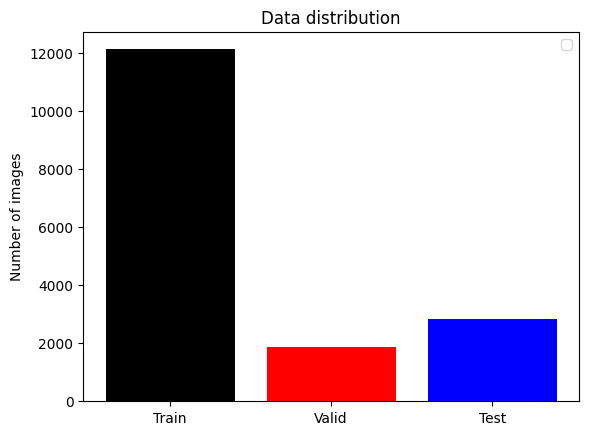

In [14]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_set), len(val_set), len(test_set)], align='center',color=[ 'black','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

print(len(train_set))
print(len(val_set))
print(len(test_set))
showDataLayout()

In [15]:
data_dict= train_set[18]
print(f"class in dataset sample = {list(data_dict.keys())}")
points = data_dict['points']
seg_labels = data_dict['seg_labels']
print(f"class_id = {data_dict['class_id']}, class_name = {data_dict['class_name']}")

class in dataset sample = ['class_id', 'class_name', 'points', 'seg_labels']
class_id = 4, class_name = Chair


In [16]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=True, color=PART_COLORS[seg_labels - 1], marker_size=2)
layout = dict(template="plotly_dark", title=f"{data_dict['class_name']}, class id = {data_dict['class_id']},  Shapenet Dataset", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

In [17]:
def collate_fn(batch_list):
    ret = {}
    ret['class_id'] =  torch.from_numpy(np.array([x['class_id'] for x in batch_list])).long()
    ret['class_name'] = np.array([x['class_name'] for x in batch_list])
    ret['points'] = torch.from_numpy(np.stack([x['points'] for x in batch_list], axis=0)).float()
    ret['seg_labels'] = torch.from_numpy(np.stack([x['seg_labels'] for x in batch_list], axis=0)).long()
    return ret

In [18]:
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=16, num_workers=2, shuffle=True, collate_fn=collate_fn) 
dataloader_iter = iter(sample_loader)   
batch_dict = next(dataloader_iter)
print(batch_dict.keys())
for key in ['points','seg_labels', 'class_id']:
    print(f"batch_dict[{key}].shape = {batch_dict[key].shape}")

dict_keys(['class_id', 'class_name', 'points', 'seg_labels'])
batch_dict[points].shape = torch.Size([16, 2500, 3])
batch_dict[seg_labels].shape = torch.Size([16, 2500])
batch_dict[class_id].shape = torch.Size([16])


In [19]:
batchSize= 64
workers = 2
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchSize,shuffle=True, num_workers=workers, collate_fn=collate_fn)

In [20]:
class STN3d(nn.Module):

    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.num_points = num_points
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        
        self.mp1 = torch.nn.MaxPool1d(num_points)
        
        # FC layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        
        # Expected input shape = (bs, 3, num_points)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

In [21]:
test_model = STN3d().to(device)
sim_data = Variable(torch.rand(32,3,2500)).to(device)
out = test_model(sim_data)
print('stn', out.size())

stn torch.Size([32, 3, 3])


In [22]:
class OpenShape(nn.Module):
    def __init__(self, num_points = 2500):
        super(OpenShape, self).__init__()

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = self.mp1(x)
        return x

In [23]:
test_model = OpenShape().to(device)
sim_data = Variable(torch.rand(32,3,2500)).to(device)
out = test_model(sim_data)
print('stn', out.size())

stn torch.Size([32, 1024, 1])


In [24]:
class PointNetfeat(nn.Module):

    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d(num_points = num_points)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat
        self.OpenShape = OpenShape(num_points = num_points)

    def forward(self, x):
        batchsize = x.size()[0]
        trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans)
        x = x.transpose(2,1)
        x = F.elu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.mp1(x)
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x, pointfeat], 1), trans

In [25]:
pointfeat = PointNetfeat(global_feat=True).to(device)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False).to(device)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])


In [26]:
def dice_score(pred, target):
    smooth = 1e-8
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

In [27]:
def train_model(model, num_epochs, criterion, optimizer, dataloader_train,
                label_str='class_id', lr_scheduler=None, output_name='pointnet.pth'):
    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        dice_scores = 0.0
        y_true = []
        y_scores = []

        for batch_dict in tqdm(dataloader_train, total=len(dataloader_train)):            
            # Forward pass
            x = batch_dict['points'].transpose(1, 2).to(device)
            labels = batch_dict[label_str].to(device)
            pred, _,_ = model(x)
            loss = criterion(pred, labels)
            train_loss += loss.item()
              
            # Calculate accuracy
            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            # Calculate Dice Score
            pred_binary = F.softmax(pred, dim=1)[:, 1] > 0.5  # Assuming binary classification
            dice_scores += dice_score(pred_binary, labels)

      

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
                 # compute per epoch losses, accuracy, Dice Score, and AUC
        train_loss = train_loss / len(dataloader_train)
        accuracy = correct_predictions / total_samples
        avg_dice_score = dice_scores / len(dataloader_train)


        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:6.5f},  Dice Score: {avg_dice_score:.4f}')

    torch.save(model.state_dict(), output_name)

In [28]:
class PointNetDenseSeg(nn.Module):
    def __init__(self, num_points=2500, num_classes=16, num_instances=10):
        super(PointNetDenseSeg, self).__init__()
        self.num_points = num_points
        self.num_classes = num_classes
        self.num_instances = num_instances

        # Feature extraction using PointNetfeat
        self.feat = PointNetfeat(num_points, global_feat=False)

        # Semantic segmentation layers
        self.conv1_sem = torch.nn.Conv1d(1088, 512, 1)
        self.conv2_sem = torch.nn.Conv1d(512, 256, 1)
        self.conv3_sem = torch.nn.Conv1d(256, 128, 1)
        self.conv4_sem = torch.nn.Conv1d(128, num_classes, 1)
        self.bn1_sem = nn.BatchNorm1d(512)
        self.bn2_sem = nn.BatchNorm1d(256)
        self.bn3_sem = nn.BatchNorm1d(128)

        # Instance segmentation layers
        self.conv1_inst = torch.nn.Conv1d(1088, 512, 1)
        self.conv2_inst = torch.nn.Conv1d(512, 256, 1)
        self.conv3_inst = torch.nn.Conv1d(256, 128, 1)
        self.conv4_inst = torch.nn.Conv1d(128, num_instances, 1)
        self.bn1_inst = nn.BatchNorm1d(512)
        self.bn2_inst = nn.BatchNorm1d(256)
        self.bn3_inst = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)

        # Semantic segmentation branch
        x_sem = F.relu(self.bn1_sem(self.conv1_sem(x)))
        x_sem = F.relu(self.bn2_sem(self.conv2_sem(x_sem)))
        x_sem = F.relu(self.bn3_sem(self.conv3_sem(x_sem)))
        x_sem = self.conv4_sem(x_sem)

        # Instance segmentation branch
        x_inst = F.relu(self.bn1_inst(self.conv1_inst(x)))
        x_inst = F.relu(self.bn2_inst(self.conv2_inst(x_inst)))
        x_inst = F.relu(self.bn3_inst(self.conv3_inst(x_inst)))
        x_inst = self.conv4_inst(x_inst)

        return x_sem, x_inst, trans

In [29]:
sseg = PointNetDenseSeg().to(device)
out, _,_ = sseg(sim_data)
print('sseg', out.size())

sseg torch.Size([32, 16, 2500])


In [30]:
epoch = 20
weight_decay = 1e-4
max_lr = 1e-3
num_points = 2500
num_classes = 16
criterion = nn.CrossEntropyLoss()

# create model, optimizer, lr_scheduler and pass to training function
num_classes = len(class_id_name_map.items())
classifier = PointNetDenseSeg(num_points = num_points)

# DEFINE OPTIMIZERS
optimizer = torch.optim.AdamW(classifier.parameters(), lr=max_lr, weight_decay=weight_decay)
if torch.cuda.is_available():
    classifier.cuda()

In [31]:
%%time
history = train_model(classifier, epoch, criterion, optimizer, train_loader, 
            label_str='seg_labels', output_name='pointnet_se_seg.pth')

Starting 1 epoch ...


100%|██████████| 190/190 [02:06<00:00,  1.50it/s]


Epoch: 1, Train Loss: 0.70089,  Dice Score: 0.5078
Starting 2 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 2, Train Loss: 0.40051,  Dice Score: 0.5987
Starting 3 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 3, Train Loss: 0.33474,  Dice Score: 0.5970
Starting 4 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 4, Train Loss: 0.30549,  Dice Score: 0.5845
Starting 5 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.34it/s]


Epoch: 5, Train Loss: 0.28126,  Dice Score: 0.5813
Starting 6 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.34it/s]


Epoch: 6, Train Loss: 0.25899,  Dice Score: 0.5779
Starting 7 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 7, Train Loss: 0.24980,  Dice Score: 0.5788
Starting 8 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 8, Train Loss: 0.24385,  Dice Score: 0.5786
Starting 9 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 9, Train Loss: 0.23699,  Dice Score: 0.5758
Starting 10 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 10, Train Loss: 0.22888,  Dice Score: 0.5742
Starting 11 epoch ...


100%|██████████| 190/190 [02:23<00:00,  1.33it/s]


Epoch: 11, Train Loss: 0.22241,  Dice Score: 0.5752
Starting 12 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 12, Train Loss: 0.21924,  Dice Score: 0.5731
Starting 13 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 13, Train Loss: 0.21133,  Dice Score: 0.5744
Starting 14 epoch ...


100%|██████████| 190/190 [02:23<00:00,  1.33it/s]


Epoch: 14, Train Loss: 0.21024,  Dice Score: 0.5740
Starting 15 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.34it/s]


Epoch: 15, Train Loss: 0.21094,  Dice Score: 0.5741
Starting 16 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 16, Train Loss: 0.20464,  Dice Score: 0.5736
Starting 17 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 17, Train Loss: 0.20141,  Dice Score: 0.5738
Starting 18 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 18, Train Loss: 0.19833,  Dice Score: 0.5734
Starting 19 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 19, Train Loss: 0.19570,  Dice Score: 0.5731
Starting 20 epoch ...


100%|██████████| 190/190 [02:22<00:00,  1.33it/s]


Epoch: 20, Train Loss: 0.19322,  Dice Score: 0.5720
CPU times: user 46min 59s, sys: 12.6 s, total: 47min 11s
Wall time: 47min 17s


In [32]:
classifier.load_state_dict(torch.load('pointnet_se_seg.pth'))
classifier.eval()

total_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_dict in tqdm(test_loader, total=len(test_loader)):
        x = batch_dict['points'].transpose(1, 2).to(device)
        labels = batch_dict['seg_labels'].to(device)
        pred, _,_ = classifier(x)

        # calculate loss
        loss = criterion(pred, labels)
        total_loss += loss.item()

        # calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

evaluation_loss = total_loss / len(test_loader)
accuracy = correct_predictions / total_samples
print(evaluation_loss)
print(f"Evaluation Loss: {evaluation_loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

/tmp/ipykernel_30/1752426128.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 45/45 [00:16<00:00,  2.80it/s]

0.28853829205036163
Evaluation Loss: 0.2885


In [41]:
# Random test sample
test_sample = test_set[2047]
batch_dict = collate_fn([test_sample])

# Get model predictions
x = batch_dict['points'].transpose(1, 2).to(device)
model_preds, _, _ = classifier(x)
pred_part_labels = torch.argmax(model_preds, axis=1).detach().cpu().numpy()[0]

points = test_sample['points']
part_labels = test_sample['seg_labels']


# plot results
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], column_widths=[0.5, 0.5],
                    subplot_titles=('Part Labels', 'Part Predictions'))

# ground truth part labels
part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[part_labels - 1], marker_size=2)

# ground truth part labels
pred_part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[pred_part_labels - 1], marker_size=2)

fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 720, width = 1280,
                title='PointNet Semantic Segmentation', title_x=0.5, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))
fig.add_trace(part_label_plots, row=1, col=1)
fig.add_trace(pred_part_label_plots, row=1, col=2)
#fig.add_trace(plot_pc_data3d(x=test_sample['points'][:,0], y=test_sample['points'][:,1], z=test_sample['points'][:,2]), row=1, col=1)
#fig.add_trace(go.Bar(x=list(class_name_id_map.keys()), y=pred_class_probs, showlegend=False), row=1, col=2)
fig.show()

In [43]:
import open3d as o3d
import numpy as np

# Save the point cloud data
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)  # Set the 3D points
colors = np.array([PART_COLORS[label - 1] for label in pred_part_labels])  # Predicted labels for coloring
pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)  # Normalize RGB to [0, 1]

# Save as a PLY file
output_file = "pointnet_predictions14.ply"
o3d.io.write_point_cloud(output_file, pcd)

# Confirm file saved
print(f"Point cloud saved as {output_file}")


Point cloud saved as pointnet_predictions14.ply


In [44]:
# Random test sample
test_sample = test_set[54]
batch_dict = collate_fn([test_sample])

# Get model predictions
x = batch_dict['points'].transpose(1, 2).to(device)
pred_part_labels, pred_inst_ids, _ = classifier(x)  # Assuming the model returns both part labels and instance IDs

# Convert predictions to numpy arrays
pred_part_labels = torch.argmax(pred_part_labels, axis=1).detach().cpu().numpy()[0]
pred_inst_ids = torch.argmax(pred_inst_ids, axis=1).detach().cpu().numpy()[0]

points = test_sample['points']
part_labels = test_sample['seg_labels']

# Plot results
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], column_widths=[0.5, 0.5],
                    subplot_titles=('Part Labels', 'Instance IDs'))

# Ground truth part labels
part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[part_labels - 1], marker_size=2)

# Predicted part labels
pred_part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[pred_part_labels - 1], marker_size=2)

# Predicted instance IDs
pred_inst_id_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS0[pred_inst_ids], marker_size=2)

fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 720, width = 1280,
                title='PointNet Semantic Segmentation', title_x=0.5, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))
fig.add_trace(part_label_plots, row=1, col=1)
fig.add_trace(pred_part_label_plots, row=1, col=2)
fig.add_trace(pred_inst_id_plots, row=1, col=2)  # Add predicted instance IDs
fig.show()

In [45]:
import open3d as o3d
import numpy as np

# Save the point cloud data
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)  # Set the 3D points
colors = np.array([PART_COLORS[label - 1] for label in pred_part_labels])  # Predicted labels for coloring
pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)  # Normalize RGB to [0, 1]

# Save as a PLY file
output_file = "pointnet_predictions15.ply"
o3d.io.write_point_cloud(output_file, pcd)

# Confirm file saved
print(f"Point cloud saved as {output_file}")


Point cloud saved as pointnet_predictions15.ply


In [35]:
# Random test sample
test_sample = test_set[2222]
batch_dict = collate_fn([test_sample])

# Get model predictions
x = batch_dict['points'].transpose(1, 2).to(device)
pred_part_labels, pred_inst_ids, _ = classifier(x)  # Assuming the model returns both part labels and instance IDs

# Convert predictions to numpy arrays
pred_part_labels = torch.argmax(pred_part_labels, axis=1).detach().cpu().numpy()[0]
pred_inst_ids = torch.argmax(pred_inst_ids, axis=1).detach().cpu().numpy()[0]

points = test_sample['points']
part_labels = test_sample['seg_labels']

# Plot results
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], column_widths=[0.5, 0.5],
                    subplot_titles=('Part Labels', 'Instance IDs'))

# Ground truth part labels
part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[part_labels - 1], marker_size=2, marker_symbol='circle')

# Predicted part labels
pred_part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[pred_part_labels - 1], marker_size=2, marker_symbol='square')

# Predicted instance IDs
pred_inst_id_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color='black', marker_size=2, marker_symbol='cross')

fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 720, width = 1280,
                title='PointNet Semantic Segmentation', title_x=0.5, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))
fig.add_trace(part_label_plots, row=1, col=1)
fig.add_trace(pred_part_label_plots, row=1, col=2)
fig.add_trace(pred_inst_id_plots, row=1, col=2)  # Add predicted instance IDs
fig.show()

In [37]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip'

In [38]:
import open3d as o3d
import numpy as np

# Save the point cloud data
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)  # Set the 3D points
colors = np.array([PART_COLORS[label - 1] for label in pred_part_labels])  # Predicted labels for coloring
pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)  # Normalize RGB to [0, 1]

# Save as a PLY file
output_file = "pointnet_predictions.ply"
o3d.io.write_point_cloud(output_file, pcd)

# Confirm file saved
print(f"Point cloud saved as {output_file}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Point cloud saved as pointnet_predictions.ply


In [ ]:
import open3d as o3d
import numpy as np

# Prepare point cloud with part labels
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)  # Set 3D points
colors = np.array([PART_COLORS[label - 1] for label in pred_part_labels])  # Use predicted labels for coloring
pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)  # Normalize RGB values to [0, 1]

# Save to PLY format
o3d.io.write_point_cloud("pointnet_predictions.ply", pcd)


In [ ]:
# Estimate normals for meshing
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Perform surface reconstruction (e.g., Poisson reconstruction)
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Save the mesh
o3d.io.write_triangle_mesh("pointnet_mesh.ply", mesh)


In [ ]:
o3d.visualization.draw_geometries([mesh])
